# Summing intensity by region

### We will download a sample brain and registration from the Boss

In [61]:
%matplotlib inline

In [2]:
import intern
import json
import matplotlib as mpl
import matplotlib.pylab as plt
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import numpy as np

In [3]:
sampleColl = 'control9_to_ara'
sampleExp = '50um_reg'
annoChan =  'annotation_50um_lddmm_withoutOlfactoryBulb2017-10-04_1233'
sampleChan = 'control9_res3'
sampleCoord = 'control9_res3'
sampleRes = 0

In [4]:
rmt = BossRemote()

In [5]:
rawResource = rmt.get_project(ChannelResource(sampleChan, sampleColl, sampleExp, datatype='uint16'))
rawCoord = rmt.get_project(CoordinateFrameResource(sampleCoord))
x_range = [rawCoord.x_start, rawCoord.x_stop]
y_range = [rawCoord.y_start, rawCoord.y_stop]
z_range = [rawCoord.z_start, rawCoord.z_stop]
rawData = rmt.get_cutout(rawResource, 0, x_range, y_range, z_range)

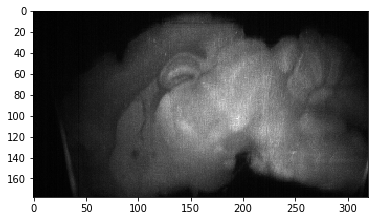

In [6]:
plt.imshow(rawData[:,:,150], cmap='gray')

In [7]:
annoResource = rmt.get_project(ChannelResource(annoChan, sampleColl, sampleExp, datatype='uint16'))
annoCoord = rmt.get_project(CoordinateFrameResource(sampleCoord))
x_range = [annoCoord.x_start, annoCoord.x_stop]
y_range = [annoCoord.y_start, annoCoord.y_stop]
z_range = [annoCoord.z_start, annoCoord.z_stop]
annoData = rmt.get_cutout(annoResource, 0, x_range, y_range, z_range)

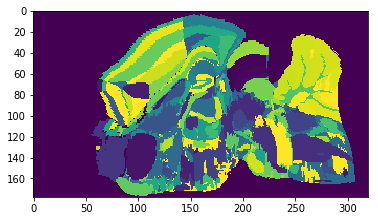

In [8]:
plt.imshow(annoData[:,:,150], vmax=1000)

### Now sum the intensity by region in the ARA

In [9]:
id2intensity = {}
for i in np.unique(annoData):
    idx = np.where(annoData == i)
    id2intensity[i] = np.sum(rawData[idx])
# verify that sums match the total sum in image
assert(np.sum(id2intensity.values()) == np.sum(rawData))

## Getting names of regions from ARA ontology

In [10]:
def getChildren(node, id2name):
    id2name[node['id']] = node['name']
    # base case
    if node['children'] == []:
        return id2name
    # other case
    for i in range(len(node['children'])):
        id2name = getChildren(node['children'][i], id2name)
    return id2name

In [11]:
# load ara ontology file
f = json.load(file('ara_structure_ontology_wo_msg.json'))[0]

In [19]:
id2name = getChildren(f, {})

In [20]:
id2name[0] = 'background'

In [26]:
id2name

{0: 'background',
 1: u'Tuberomammillary nucleus, ventral part',
 2: u'Primary somatosensory area, mouth, layer 6b',
 3: u'secondary fissure',
 4: u'Inferior colliculus',
 6: u'internal capsule',
 7: u'Principal sensory nucleus of the trigeminal',
 8: u'Basic cell groups and regions',
 9: u'Primary somatosensory area, trunk, layer 6a',
 10: u'Superior colliculus, motor related, intermediate gray layer',
 11: u'posterolateral fissure',
 12: u'Interfascicular nucleus raphe',
 10707: u'Lingula (I), molecular layer',
 15: u'Parataenial nucleus',
 16: u'Layer 6b, isocortex',
 17: u'Superior colliculus, motor related, intermediate white layer',
 18: u'nodular fissure',
 19: u'Induseum griseum',
 20: u'Entorhinal area, lateral part, layer 2',
 21: u'lateral olfactory tract, general',
 22: u'Posterior parietal association areas',
 23: u'Anterior amygdalar area',
 25: u'simple fissure',
 26: u'Superior colliculus, motor related, deep gray layer',
 27: u'Intergeniculate leaflet of the lateral ge

In [35]:
# name2intensity = {id2name[i]: id2intensity[i] for i in id2name.keys()}
name2intensity = {}
total_intensity = np.sum(id2intensity.values())
for i in id2intensity.keys():
    try:
        name2intensity[id2name[i]] = float(id2intensity[i]) / float(total_intensity)
    except:
        name2intensity[i] = float(id2intensity[i]) / float(total_intensity)
            

In [36]:
name2intensity

{u'dorsal fornix': 0.000100013933099791,
 u'Entorhinal area, lateral part': 0.009743383665621755,
 u'Infralimbic area, layer 2/3': 0.0001808044671244472,
 u'Primary somatosensory area, nose, layer 2/3': 0.0011407854809137375,
 u'Substantia nigra, reticular part': 0.003475610669339139,
 u'Primary somatosensory area, barrel field, layer 6b': 0.00027478665760194936,
 u'central canal, spinal cord/medulla': 1.7801861443227675e-06,
 u'Posterior amygdalar nucleus': 0.00041060886413302964,
 u'Orbital area, lateral part, layer 6a': 0.0006645350735398023,
 u'Central lateral nucleus of the thalamus': 0.0003997920249985744,
 u'Orbital area, lateral part, layer 6b': 8.045735358638064e-05,
 u'Preparasubthalamic nucleus': 3.180092032245112e-05,
 u'Medial vestibular nucleus': 0.0018593742851510536,
 u'trapezoid body': 0.0003328364580843151,
 u'Ventral auditory area, layer 6a': 0.0005592748783574984,
 u'Medial pretectal area': 0.0001712655450265902,
 u'Superior colliculus, motor related, intermediate w

In [52]:
max_val = 0.0
for i in name2intensity.iteritems():
    if i[1] > max_val: 
        max_val = i[1]
        max_region = i[0]
    
print('Region with most intensity: {}, Intensity: {}'.format(max_region, max_val))

Region with most intensity: background, Intensity: 0.255713253717


In [71]:
# Top 5 intensity regions
sorted_vals = np.sort(name2intensity.values())
for key, value in name2intensity.items():
    if np.isin(value, sorted_vals[-5:]):
        print('Region: {}; Intensity: {}'.format(key, value))

Region: corpus callosum; Intensity: 0.01605282227
Region: Caudoputamen; Intensity: 0.052303183911
Region: Piriform area; Intensity: 0.0141233079415
Region: Field CA1; Intensity: 0.0149920117
Region: background; Intensity: 0.255713253717
